A cerveja é uma das bebidas mais democráticas e consumidas no mundo. Não sem razão, é perfeito para quase todas as situações, desde o happy hour até grandes festas de casamento.

O objetivo deste treinamento será estimar um modelo de Machine Learning utilizando vários algoritmos de Regressão para demonstrar os impactos das variáveis disponibilizadas neste dataset sobre o consumo de cerveja (Y). No final do projeto teremos um modelo de previsão para o consumo médio de cerveja segundo os inputs de um conjunto de variáveis (X's).

Os dados (amostra) foram coletados em São Paulo - Brasil, em uma área universitária, onde existem algumas festas com grupos de alunos de 18 a 28 anos de idade (média).

Fonte de dados: https://www.kaggle.com/dongeorge/beer-consumption-sao-paulo

Descrição das colunas:

Data - Data
Temperatura_Media - Temperatura Média (°C)
Temperatura_Minima - Temperatura Mínima (°C)
Temperatura_Maxima - Temperatura Máxima (°C)
Precipitacao - Precipitação (mm)
Final_de_Semana - Final de Semana (1 = Sim; 0 = Não)
Consumo - Consumo de Cerveja (litros)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
dataset = pd.read_csv('Consumo_de_cerveja.csv')

In [3]:
dataset

,data,temp_media,temp_min,temp_max,chuva,fds,consumo
0,2015-01-01,27.30,23.9,32.5,0.0,0,25461
1,2015-01-02,27.02,24.5,33.5,0.0,0,28972
2,2015-01-03,24.82,22.4,29.9,0.0,1,30814
3,2015-01-04,23.98,21.5,28.6,1.2,1,29799
4,2015-01-05,23.82,21.0,28.3,0.0,0,28900
...,...,...,...,...,...,...,...
360,2015-12-27,24.00,21.1,28.2,13.6,1,32307
361,2015-12-28,22.64,21.1,26.7,0.0,0,26095
362,2015-12-29,21.68,20.3,24.1,10.3,0,22309
363,2015-12-30,21.38,19.3,22.4,6.3,0,20467


In [4]:
dataset['data'] = pd.to_datetime(dataset['data'])

In [5]:
meses = {
     'January': 'Janeiro',
    'February': 'Fevereiro',
    'March': 'Março',
    'April' : 'Abril',
    'May': 'Maio',
    'June': 'Junho',
    'July' : 'Julho',
    'August' : 'Agosto',
    'September' : 'Setembro',
    'October' : 'Outubro',
    'November' : 'Novembro',
    'December' : 'Dezembro'
}

dias = {
     'Sunday' : 'Domingo', 
    'Monday' : 'Segunda-feira', 
    'Tuesday' : 'Terça-feira', 
    'Wednesday' : 'Quarta-feira', 
    'Thursday' : 'Quinta-feira', 
    'Friday' : 'Sexta-feira',
    'Saturday' : 'Sábado'
}

In [6]:
dataset['mes'] = dataset['data'].apply(lambda d: d.strftime('%B'))
dataset['dia'] = dataset['data'].apply(lambda d: d.strftime('%A'))
dataset['mes'] = dataset['mes'].map(meses)
dataset['dia'] = dataset['dia'].map(dias)

In [7]:
dataset.head()

,data,temp_media,temp_min,temp_max,chuva,fds,consumo,mes,dia
0,2015-01-01,27.30,23.9,32.5,0.0,0,25461,Janeiro,Quinta-feira
1,2015-01-02,27.02,24.5,33.5,0.0,0,28972,Janeiro,Sexta-feira
2,2015-01-03,24.82,22.4,29.9,0.0,1,30814,Janeiro,Sábado
3,2015-01-04,23.98,21.5,28.6,1.2,1,29799,Janeiro,Domingo
4,2015-01-05,23.82,21.0,28.3,0.0,0,28900,Janeiro,Segunda-feira


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   data        365 non-null    datetime64[ns]
 1   temp_media  365 non-null    float64       
 2   temp_min    365 non-null    float64       
 3   temp_max    365 non-null    float64       
 4   chuva       365 non-null    float64       
 5   fds         365 non-null    int64         
 6   consumo     365 non-null    int64         
 7   mes         365 non-null    object        
 8   dia         365 non-null    object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 25.8+ KB


In [9]:
dataset.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
temp_media,365.0,21.226,3.180,12.9,19.02,21.38,23.28,28.86
temp_min,365.0,17.461,2.826,10.6,15.30,17.90,19.60,24.50
temp_max,365.0,26.612,4.317,14.5,23.80,26.90,29.40,36.50
chuva,365.0,5.197,12.418,0.0,0.00,0.00,3.20,94.80
fds,365.0,0.285,0.452,0.0,0.00,0.00,1.00,1.00
consumo,365.0,25401.367,4399.143,14343.0,22008.00,24867.00,28631.00,37937.00


correlação da variáveis

In [10]:
corr = dataset.corr(method='pearson').round(3)
corr

,temp_media,temp_min,temp_max,chuva,fds,consumo
temp_media,1.000,0.863,0.923,0.024,-0.051,0.575
temp_min,0.863,1.000,0.673,0.099,-0.060,0.393
temp_max,0.923,0.673,1.000,-0.049,-0.040,0.643
chuva,0.024,0.099,-0.049,1.000,0.002,-0.194
fds,-0.051,-0.060,-0.040,0.002,1.000,0.506
consumo,0.575,0.393,0.643,-0.194,0.506,1.000


In [11]:
sns.set_palette('Accent')
sns.set_style('darkgrid')

<AxesSubplot:>

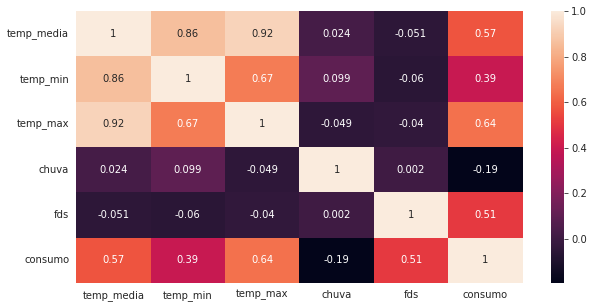

In [12]:
plt.figure(figsize=(10, 5))
sns.heatmap(data=corr, annot=True)

Comportamento da variável dependente

Text(0, 0.5, 'litros')

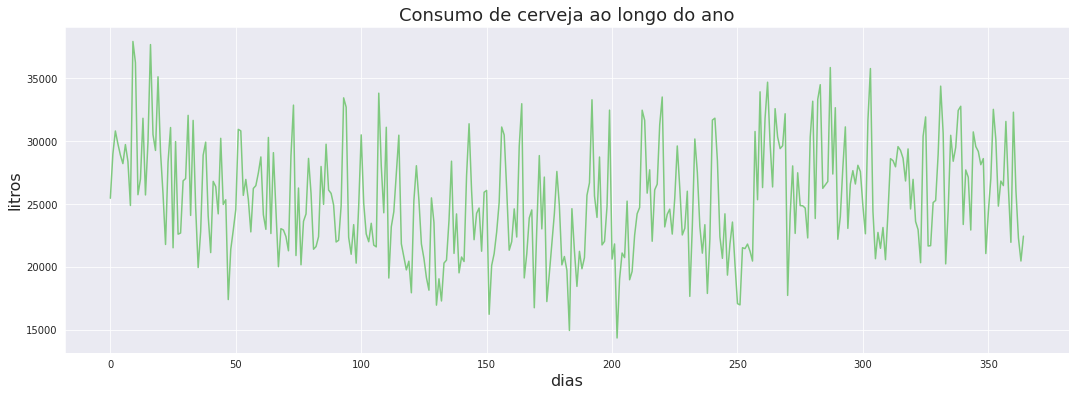

In [13]:
plt.figure(figsize=(18, 6))
dataset['consumo'].plot(kind='line')
plt.title('Consumo de cerveja ao longo do ano', fontsize=18)
plt.xlabel('dias', fontsize=16)
plt.ylabel('litros', fontsize=16)

Text(0, 0.5, 'Temperatura')

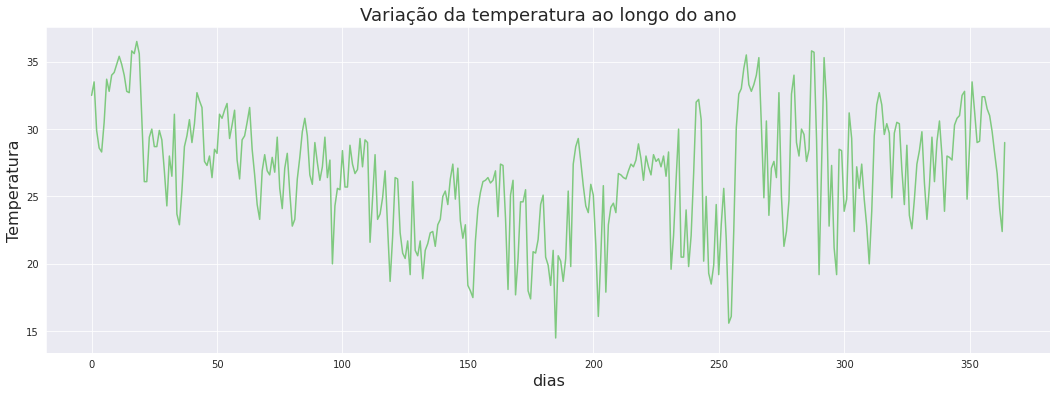

In [14]:
plt.figure(figsize=(18, 6))
dataset['temp_max'].plot(kind='line')
plt.title('Variação da temperatura ao longo do ano', fontsize=18)
plt.xlabel('dias', fontsize=16)
plt.ylabel('Temperatura', fontsize=16)

Text(0.5, 1.0, 'Consumo de cerveja')

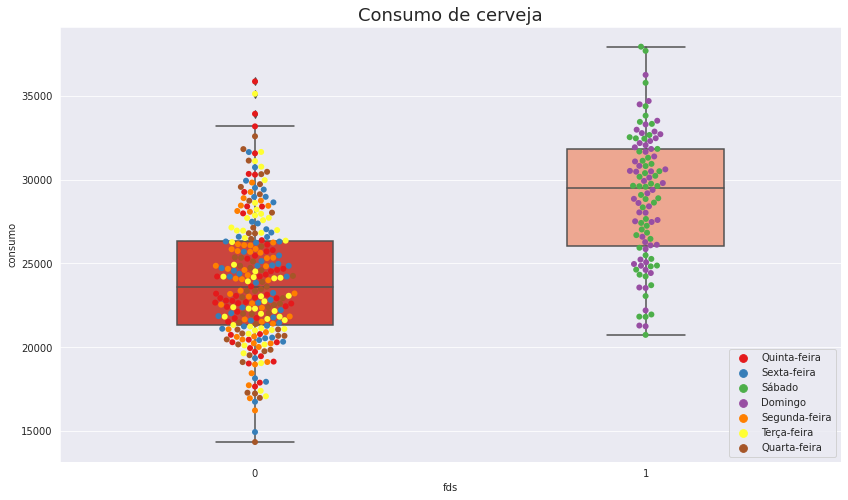

In [15]:
plt.figure(figsize=(14,8))
ax = sns.boxplot(x='fds', y='consumo', data=dataset, width=0.4, palette='Reds_r')
ax = sns.swarmplot(x='fds', y='consumo', data=dataset, hue='dia',  palette='Set1', size=6)
ax.legend(loc='lower right')
ax.set_title('Consumo de cerveja', fontsize=18)

Text(0.5, 1.0, 'Temperatura Máxima')

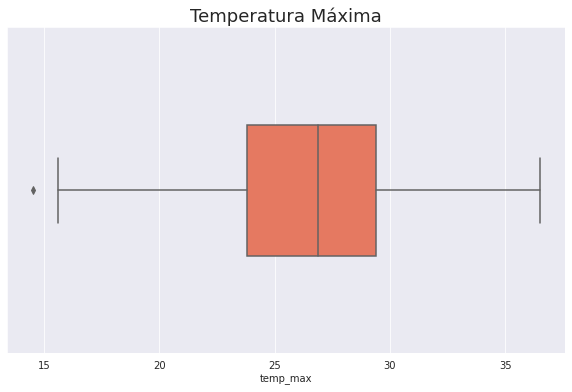

In [16]:
ax = sns.boxplot(x='temp_max', data=dataset, width=0.4, palette='Reds_r')
ax.figure.set_size_inches(10, 6)
ax.set_title('Temperatura Máxima', fontsize=18)

In [17]:
dataset.columns[1:6]

Index(['temp_media', 'temp_min', 'temp_max', 'chuva', 'fds'], dtype='object')

Text(0.5, 1.1, 'Dispersão entre as variaveis')

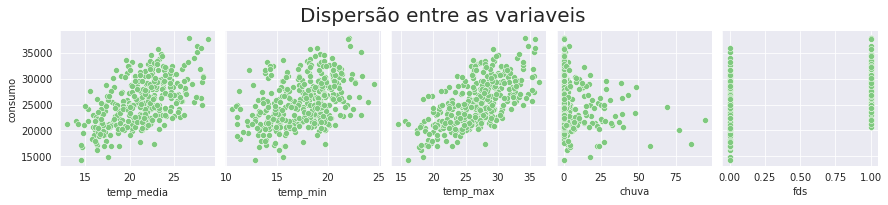

In [18]:
sns.pairplot(data=dataset, y_vars='consumo', x_vars=dataset.columns[1:6])
plt.suptitle('Dispersão entre as variaveis', fontsize=20, y=1.10)

Text(0.5, 1.1, 'Dispersão entre as variaveis')

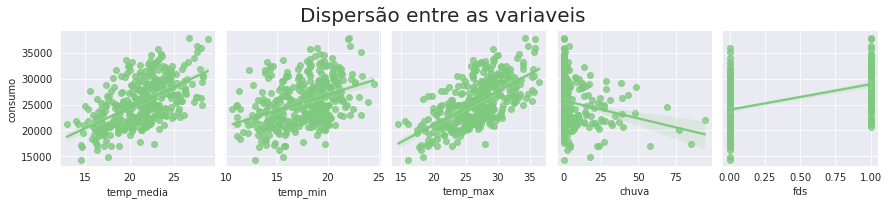

In [19]:
sns.pairplot(data=dataset, y_vars='consumo', x_vars=dataset.columns[1:6], kind='reg')
plt.suptitle('Dispersão entre as variaveis', fontsize=20, y=1.10)

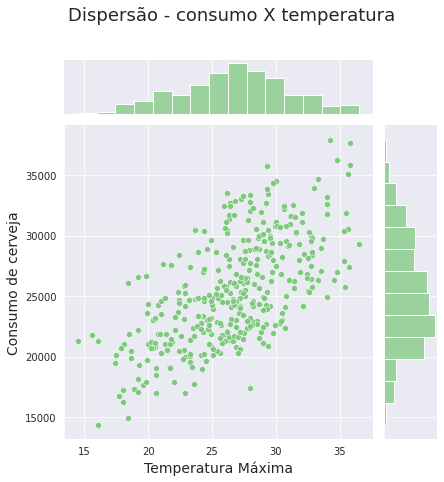

In [20]:
ax = sns.jointplot(x='temp_max', y='consumo', data=dataset)
ax.fig.suptitle('Dispersão - consumo X temperatura', fontsize=18, y=1.10)
ax.set_axis_labels('Temperatura Máxima', 'Consumo de cerveja', fontsize=14)

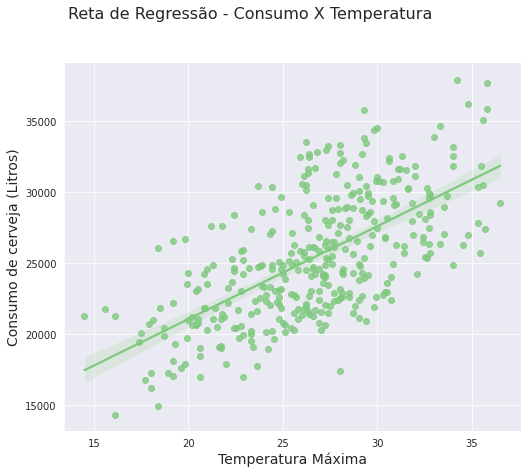

In [21]:
ax = sns.lmplot(x='temp_max', y='consumo', data=dataset)
ax.figure.set_size_inches(8, 6)
ax.fig.suptitle('Reta de Regressão - Consumo X Temperatura', fontsize=16, y=1.10)
ax.set_xlabels('Temperatura Máxima', fontsize=14)
ax.set_ylabels('Consumo de cerveja (Litros)', fontsize=14)

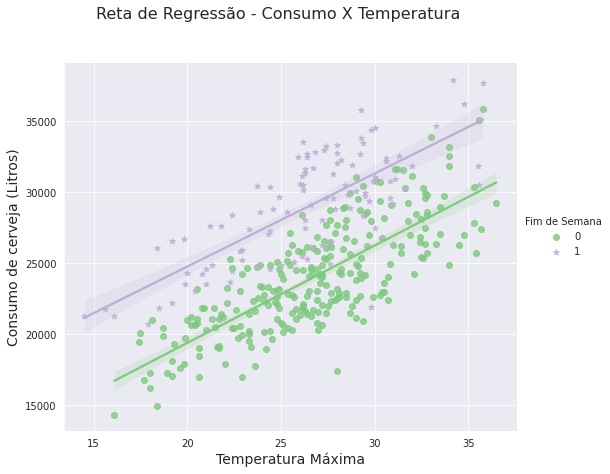

In [22]:
ax = sns.lmplot(x='temp_max', y='consumo', hue='fds',
                markers=['o', '*'], legend=False, data=dataset)
ax.figure.set_size_inches(8, 6)
ax.fig.suptitle('Reta de Regressão - Consumo X Temperatura', fontsize=16, y=1.10)
ax.set_xlabels('Temperatura Máxima', fontsize=14)
ax.set_ylabels('Consumo de cerveja (Litros)', fontsize=14)
ax.add_legend(title='Fim de Semana')

Construindo classes de amplitude fixa com a regra de Sturges

In [23]:
n = dataset.shape[0]

In [24]:
int(1 + (10/3)* np.log10(n))

9

In [25]:
pd.value_counts(pd.cut(dataset['temp_max'], bins=9, include_lowest=True), sort=False)

(14.477, 16.944]     4
(16.944, 19.389]    18
(19.389, 21.833]    35
(21.833, 24.278]    43
(24.278, 26.722]    80
(26.722, 29.167]    83
(29.167, 31.611]    57
(31.611, 34.056]    31
(34.056, 36.5]      14
Name: temp_max, dtype: int64

In [26]:
dataset['temp_cat'] = pd.cut(dataset['temp_max'], bins=9, include_lowest=True)

In [27]:
dataset

,data,temp_media,temp_min,temp_max,chuva,fds,consumo,mes,dia,temp_cat
0,2015-01-01,27.30,23.9,32.5,0.0,0,25461,Janeiro,Quinta-feira,"(31.611, 34.056]"
1,2015-01-02,27.02,24.5,33.5,0.0,0,28972,Janeiro,Sexta-feira,"(31.611, 34.056]"
2,2015-01-03,24.82,22.4,29.9,0.0,1,30814,Janeiro,Sábado,"(29.167, 31.611]"
3,2015-01-04,23.98,21.5,28.6,1.2,1,29799,Janeiro,Domingo,"(26.722, 29.167]"
4,2015-01-05,23.82,21.0,28.3,0.0,0,28900,Janeiro,Segunda-feira,"(26.722, 29.167]"
...,...,...,...,...,...,...,...,...,...,...
360,2015-12-27,24.00,21.1,28.2,13.6,1,32307,Dezembro,Domingo,"(26.722, 29.167]"
361,2015-12-28,22.64,21.1,26.7,0.0,0,26095,Dezembro,Segunda-feira,"(24.278, 26.722]"
362,2015-12-29,21.68,20.3,24.1,10.3,0,22309,Dezembro,Terça-feira,"(21.833, 24.278]"
363,2015-12-30,21.38,19.3,22.4,6.3,0,20467,Dezembro,Quarta-feira,"(21.833, 24.278]"


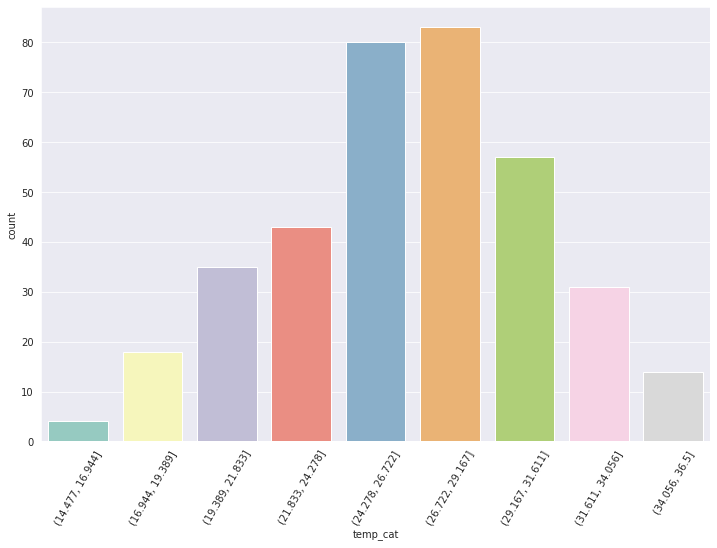

In [28]:
plt.figure(figsize=(12, 8))
sns.countplot(x='temp_cat', data=dataset, palette='Set3')
plt.xticks(rotation=60)
plt.show()

Quando utilizamos métodos de amostragem unicamente aleatórios, corremos o risco de introduzir um viés de amostragem(caso o conjunto de dados não seja grande o bastante).

In [29]:
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

proporções de categorias de temperatura maxima no conjunto de dados completo

In [30]:
dataset['temp_cat'].value_counts()/dataset.shape[0]

(26.722, 29.167]    0.227397
(24.278, 26.722]    0.219178
(29.167, 31.611]    0.156164
(21.833, 24.278]    0.117808
(19.389, 21.833]    0.095890
(31.611, 34.056]    0.084932
(16.944, 19.389]    0.049315
(34.056, 36.5]      0.038356
(14.477, 16.944]    0.010959
Name: temp_cat, dtype: float64

proporções de categorias de temperatura maxima no conjunto de dados de teste
gerado com amostragem aleatória.

In [31]:
test_set['temp_cat'].value_counts()/len(test_set)

(26.722, 29.167]    0.246575
(29.167, 31.611]    0.232877
(24.278, 26.722]    0.150685
(19.389, 21.833]    0.095890
(21.833, 24.278]    0.095890
(31.611, 34.056]    0.095890
(16.944, 19.389]    0.054795
(34.056, 36.5]      0.027397
(14.477, 16.944]    0.000000
Name: temp_cat, dtype: float64

In [32]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(dataset, dataset['temp_cat']):
    strat_train = dataset.loc[train_index]
    strat_test = dataset.loc[test_index]

proporções de categorias de temperatura maxima no conjunto de dados de teste
gerado com amostragem estratificada.

In [33]:
strat_test['temp_cat'].value_counts() / len(strat_test)

(24.278, 26.722]    0.219178
(26.722, 29.167]    0.219178
(29.167, 31.611]    0.150685
(21.833, 24.278]    0.123288
(19.389, 21.833]    0.095890
(31.611, 34.056]    0.082192
(16.944, 19.389]    0.054795
(34.056, 36.5]      0.041096
(14.477, 16.944]    0.013699
Name: temp_cat, dtype: float64

irei estimar o modelo de regressão com as variaveis: temp_max, chuva e fds

In [35]:
strat_train_target = strat_train['consumo']
strat_test_target = strat_test['consumo']

In [36]:
drop = ['data', 'temp_media', 'temp_min', 'mes', 'dia', 'temp_cat', 'consumo']

In [37]:
for set_ in (strat_train, strat_test):
    set_.drop(labels=drop, axis=1, inplace=True)

In [38]:
scaler = StandardScaler()
strat_train_prepared = scaler.fit_transform(strat_train)

In [39]:
def scores(scores):
    print(f'scores: {scores.round(3)}')
    print(f'mean: {scores.mean().round(3)}')
    print(f'standard deviation: {scores.std().round(3)}')

Dummy Regressor

In [40]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(strat_train_prepared, strat_train_target)
dummy_predict = dummy.predict(strat_train_prepared)
np.sqrt(mean_squared_error(strat_train_target, dummy_predict))

4309.565208276505

In [41]:
scores_dummy = cross_val_score(dummy, strat_train_prepared, strat_train_target,
               scoring='neg_mean_squared_error', cv=5)

In [42]:
sqrt_scores_dummy = np.sqrt(-scores_dummy)
scores(sqrt_scores_dummy)

scores: [4507.96  4306.302 4130.039 4350.544 4299.911]
mean: 4318.951
standard deviation: 120.775


Regressão Linear

In [65]:
lin_reg = LinearRegression()
lin_reg.fit(strat_train_prepared, strat_train_target)
print(f'intercept: {lin_reg.intercept_}')
print(f'coefs: {lin_reg.coef_}')

intercept: 25398.383561643837
coefs: [2743.89334774 -743.34896923 2302.40013808]


In [45]:
lin_predicts = lin_reg.predict(strat_train_prepared)
np.sqrt(mean_squared_error(strat_train_target, lin_predicts))

2366.0675008851795

In [46]:
scores_lin = cross_val_score(lin_reg, strat_train_prepared, strat_train_target,
                         scoring='neg_mean_squared_error', cv=5)

sqrt_scores_lin = np.sqrt(-scores_lin)
scores(sqrt_scores_lin)

scores: [2510.535 2363.399 2230.191 2365.825 2530.999]
mean: 2400.19
standard deviation: 110.201


Árvores de Decisão 

In [47]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(strat_train_prepared, strat_train_target)
tree_predict = tree_reg.predict(strat_train_prepared)
np.sqrt(mean_squared_error(strat_train_target, tree_predict))

940.5899415105268

In [48]:
scores_tree = cross_val_score(tree_reg, strat_train_prepared, strat_train_target,
                         scoring='neg_mean_squared_error', cv=5)

sqrt_scores_tree = np.sqrt(-scores_tree)
scores(sqrt_scores_tree)

scores: [3474.51  2903.237 3284.501 3279.455 3442.132]
mean: 3276.767
standard deviation: 202.997


Máquinas de Vetores de Suporte (SVM)

In [49]:
svr_reg = SVR(kernel='linear')
svr_reg.fit(strat_train_prepared, strat_train_target)
svr_predict = svr_reg.predict(strat_train_prepared)
np.sqrt(mean_squared_error(strat_train_target, svr_predict))

4182.611581327639

In [50]:
scores_svr = cross_val_score(svr_reg, strat_train_prepared, strat_train_target,
                         scoring='neg_mean_squared_error', cv=5)

sqrt_scores_svr = np.sqrt(-scores_svr)
scores(sqrt_scores_svr)

scores: [4463.282 4280.049 3962.323 4232.154 4187.644]
mean: 4225.091
standard deviation: 161.403


K-Nearest Neighbours (KNN)

In [51]:
knn_reg = KNeighborsRegressor()
knn_reg.fit(strat_train_prepared, strat_train_target)
knn_predict = knn_reg.predict(strat_train_prepared)
np.sqrt(mean_squared_error(strat_train_target, knn_predict))

2195.705481940749

In [52]:
scores_knn = cross_val_score(knn_reg, strat_train_prepared, strat_train_target,
                         scoring='neg_mean_squared_error', cv=5)

sqrt_scores_knn = np.sqrt(-scores_knn)
scores(sqrt_scores_knn)

scores: [2737.043 2436.184 2524.865 2545.725 3021.841]
mean: 2653.132
standard deviation: 208.826


<AxesSubplot:>

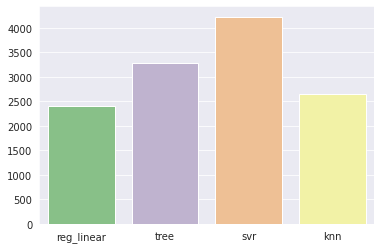

In [53]:
scores = np.array([2400.19, 3288.552, 4225.091, 2653.132])
labels = np.array(['reg_linear', 'tree', 'svr', 'knn'])

sns.barplot(x=labels, y=scores)

Lembrando que o RMSE é uma função de custo, quanto menor, melhor.

Aperfeiçoando o Modelo

Árvore de Decisão

In [54]:
params_tree = {
   'max_depth': [2*n for n in range(1, 10)],
    'min_samples_leaf': [6, 8, 10],
    'min_samples_split': [2, 4, 6]
}
grid_tree = GridSearchCV(tree_reg, params_tree, cv=5, scoring='neg_mean_squared_error')

grid_tree.fit(strat_train_prepared, strat_train_target)
print(f'best params: {grid_tree.best_params_}')
print(f'best score: {np.sqrt(-grid_tree.best_score_)}')

best params: {'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 2}
best score: 2575.3777209331656


Máquinas de Vetores de Suporte (SVM)

In [55]:
params_svr = {
    'C': [10, 20, 30, 40, 50],
    'epsilon': [0.5, 1, 1.5]
}

grid_svr = GridSearchCV(svr_reg, params_svr, cv=5, scoring='neg_mean_squared_error')

grid_svr.fit(strat_train_prepared, strat_train_target)
print(f'best params: {grid_svr.best_params_}')
print(f'best score: {np.sqrt(-grid_svr.best_score_)}')

best params: {'C': 50, 'epsilon': 1.5}
best score: 2571.7170459326526


K-Nearest Neighbours

In [56]:
params_knn = {
    'n_neighbors': [11, 13, 15, 17, 19],
    'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

grid_knn = GridSearchCV(knn_reg, params_knn, cv=5, scoring='neg_mean_squared_error')
grid_knn.fit(strat_train_prepared, strat_train_target)
print(f'best params: {grid_knn.best_params_}')
print(f'best score: {np.sqrt(-grid_knn.best_score_)}')

best params: {'algorithm': 'kd_tree', 'n_neighbors': 19, 'p': 2}
best score: 2528.878930374063


<AxesSubplot:>

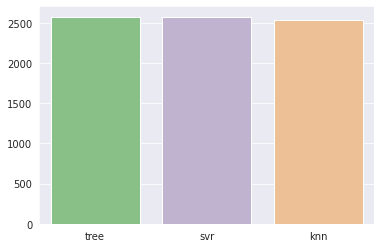

In [57]:
scores_grid = [2575.377, 2571.717, 2528.878]
labels = ['tree', 'svr', 'knn']

sns.barplot(x=labels, y=scores_grid)

avaliando modelos no conjunto de teste

In [58]:
strat_test_prepared = scaler.transform(strat_test)

Regressão Linear

In [59]:
lin_predicts = lin_reg.predict(strat_test_prepared)
np.sqrt(mean_squared_error(strat_test_target, lin_predicts))

2114.8127188516632

Árvore de Decissão

In [61]:
best_tree = grid_tree.best_estimator_
tree_predict = best_tree.predict(strat_test_prepared)
np.sqrt(mean_squared_error(strat_test_target, tree_predict))

2545.5938067176703

Máquina de Vetores de Suporte

In [62]:
best_svr = grid_svr.best_estimator_
svr_predict = best_svr.predict(strat_test_prepared)
np.sqrt(mean_squared_error(strat_test_target, svr_predict))

2437.7375447571235

K-Nearest Neighbours

In [63]:
best_knn = grid_knn.best_estimator_
knn_predict = best_svr.predict(strat_test_prepared)
np.sqrt(mean_squared_error(strat_test_target, knn_predict))

2437.7375447571235

<AxesSubplot:>

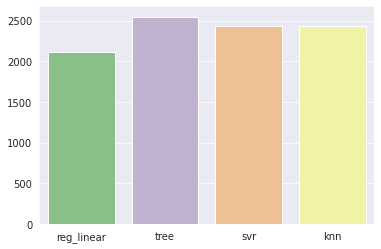

In [64]:
scores_test = [2114.812, 2545.593, 2437.737, 2437.737]
labels = ['reg_linear', 'tree', 'svr', 'knn']

sns.barplot(x=labels, y=scores_test)